In [1]:
%reload_ext autoreload
%autoreload 2
import slap2_py as spy
import wisco_slap as wis
import wisco_slap.defs as DEFS
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import h5py
import glob
import polars as pl
from pathlib import Path
import tifffile
import seaborn as sns
import electro_py as epy
import cv2
from wisco_slap.scope import SynDF

In [2]:
from ged import *

In [ ]:
df = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_group='dFF', trace_types=['matchFilt', 'events'], SDF=True)
nn = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_group='dFF', trace_types=['nonneg'], SDF=True)
dn = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_group='dFF', trace_types=['denoised'], SDF=True)
df = df.with_columns((pl.col("noise")*5).alias('nthresh'))
mf = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_group='dFF', trace_types=['matchFilt'], SDF=True)
mf = df.filter(pl.col('trace_type') == 'matchFilt')
mf = mf.with_columns((pl.col('data')/pl.col('nthresh')).alias('snr'))
ls = wis.scope.io.load_lsdf(subject, exp, loc, acq, SDF=True)
from bhm import detect_glutamate_release_events


1
2


In [ ]:
g2.write_parquet("raw_event_detection_dmd2.parquet")

In [ ]:
g2 = pl.from_pandas(detres['events'])
g2 = g2.sort('t_sec')
mfdf2 = mf.filter(pl.col('dmd')==2)
events_seconds = g2['t_sec'].to_numpy()
event_sources = g2['synapse'].to_numpy()

In [ ]:
# 1. Create a temporary DataFrame from the event arrays with an index to preserve order
qdf = pl.DataFrame({
    'time': events_seconds, 
    'source-ID': event_sources
}).with_row_index('idx')
# 2. Prepare target: Select columns and sort by source-ID then time 
# This sort is crucial to ensure 'rolling' uses the temporal neighbors correctly.
target = mfdf2.df.select(['time', 'source-ID', 'snr']).sort(['source-ID', 'time'])
# Calculate 3-sample centered rolling mean of SNR per source 
# min_periods=1 ensures we calculate a mean even if we are at the start/end (nanmean behavior)
target = target.with_columns(
    pl.col('snr').rolling_mean(window_size=3, center=True, min_periods=1).over('source-ID').alias('snr_mean')
)
# Sort by time as required for join_asof
target = target.sort('time')
# 3. Perform join_asof with tolerance using the newly calculated averaged SNR
res = qdf.join_asof(
    target, 
    on='time', 
    by='source-ID', 
    tolerance=1e-5,
    strategy='nearest'
)
# 4. Sort by the index and extract the 'snr_mean' array
event_snrs = res.sort('idx')['snr_mean'].to_numpy()
g2 = g2.with_columns(pl.lit(event_snrs).alias("mfsnr"))
g2 = g2.drop_nans(subset=['mfsnr'])

/tmp/ipykernel_2913365/3672678403.py:12: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col('snr').rolling_mean(window_size=3, center=True, min_periods=1).over('source-ID').alias('snr_mean')
/tmp/ipykernel_2913365/3672678403.py:17: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  res = qdf.join_asof(


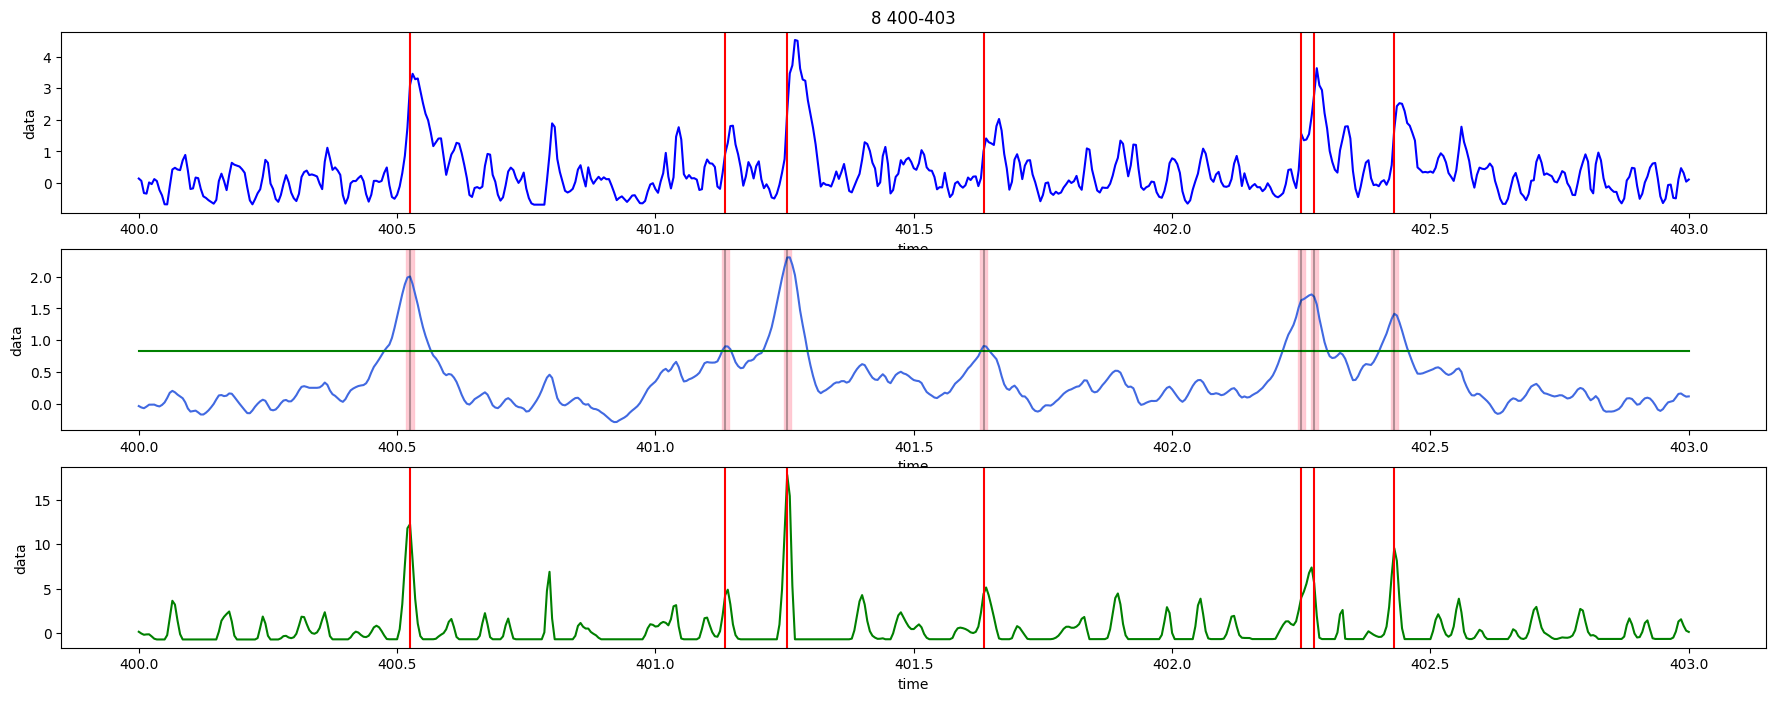

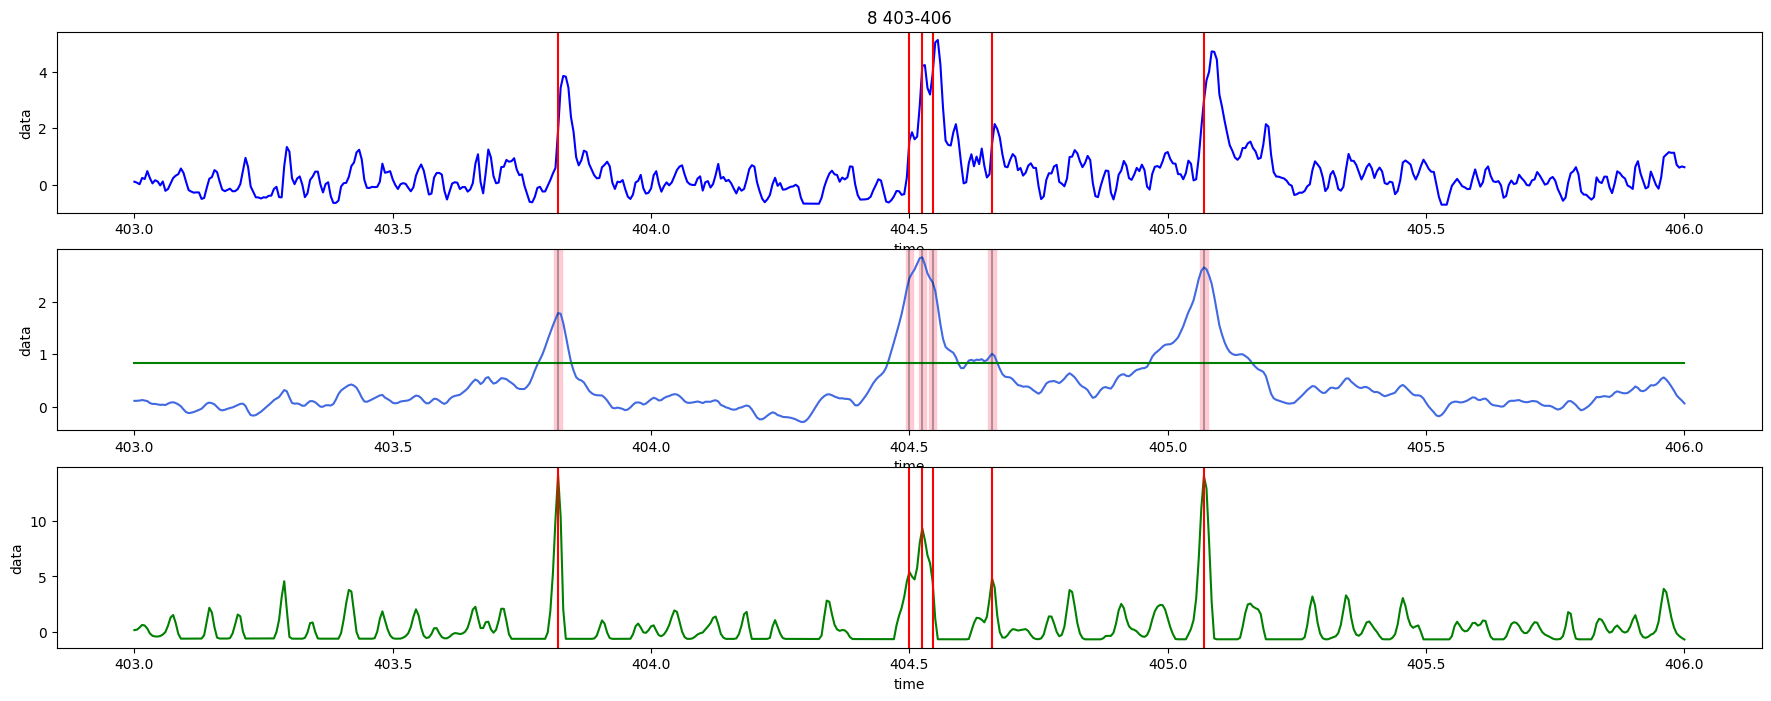

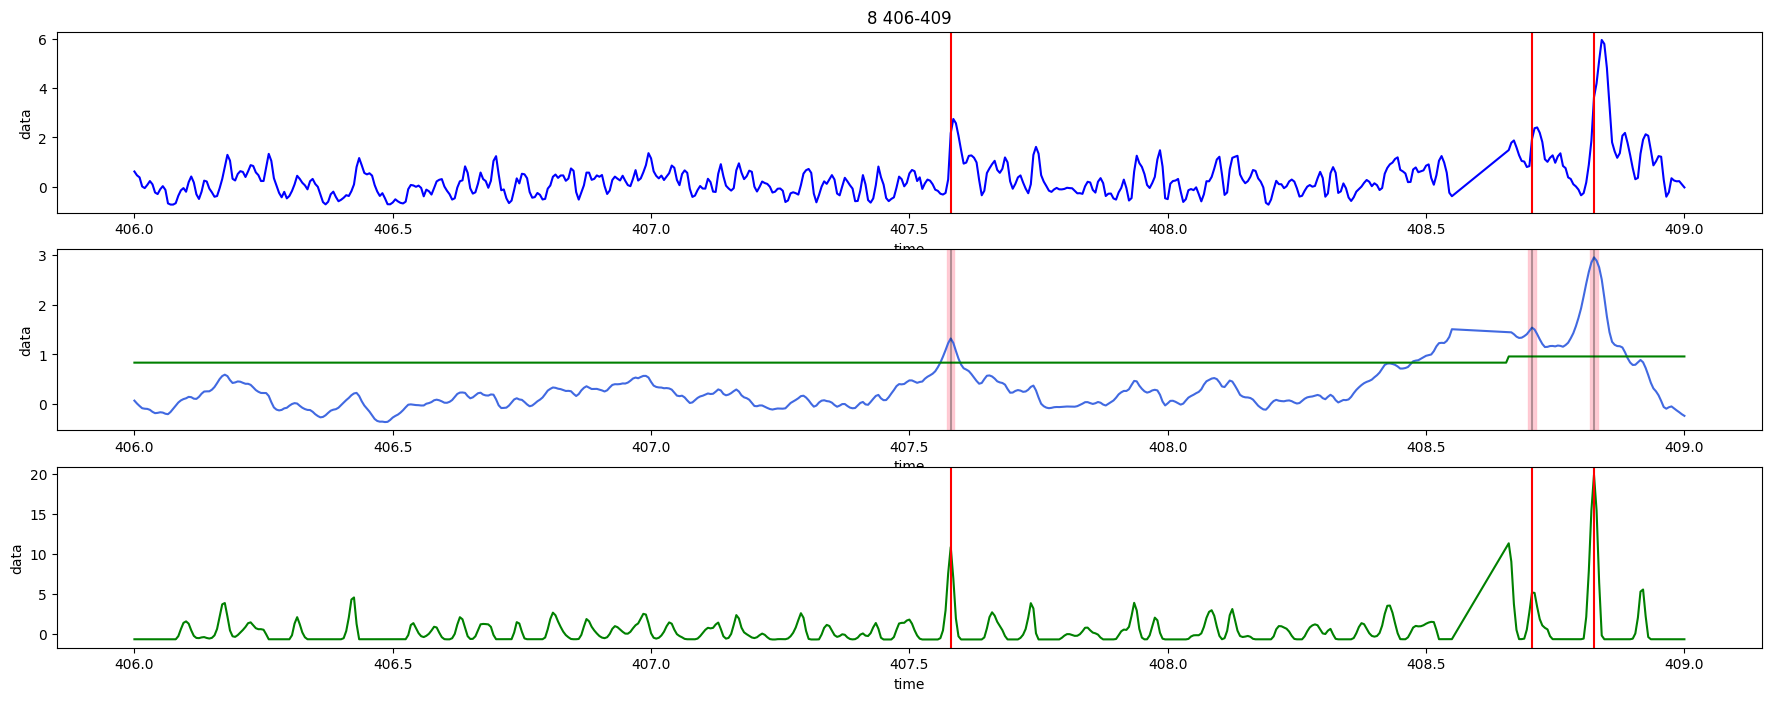

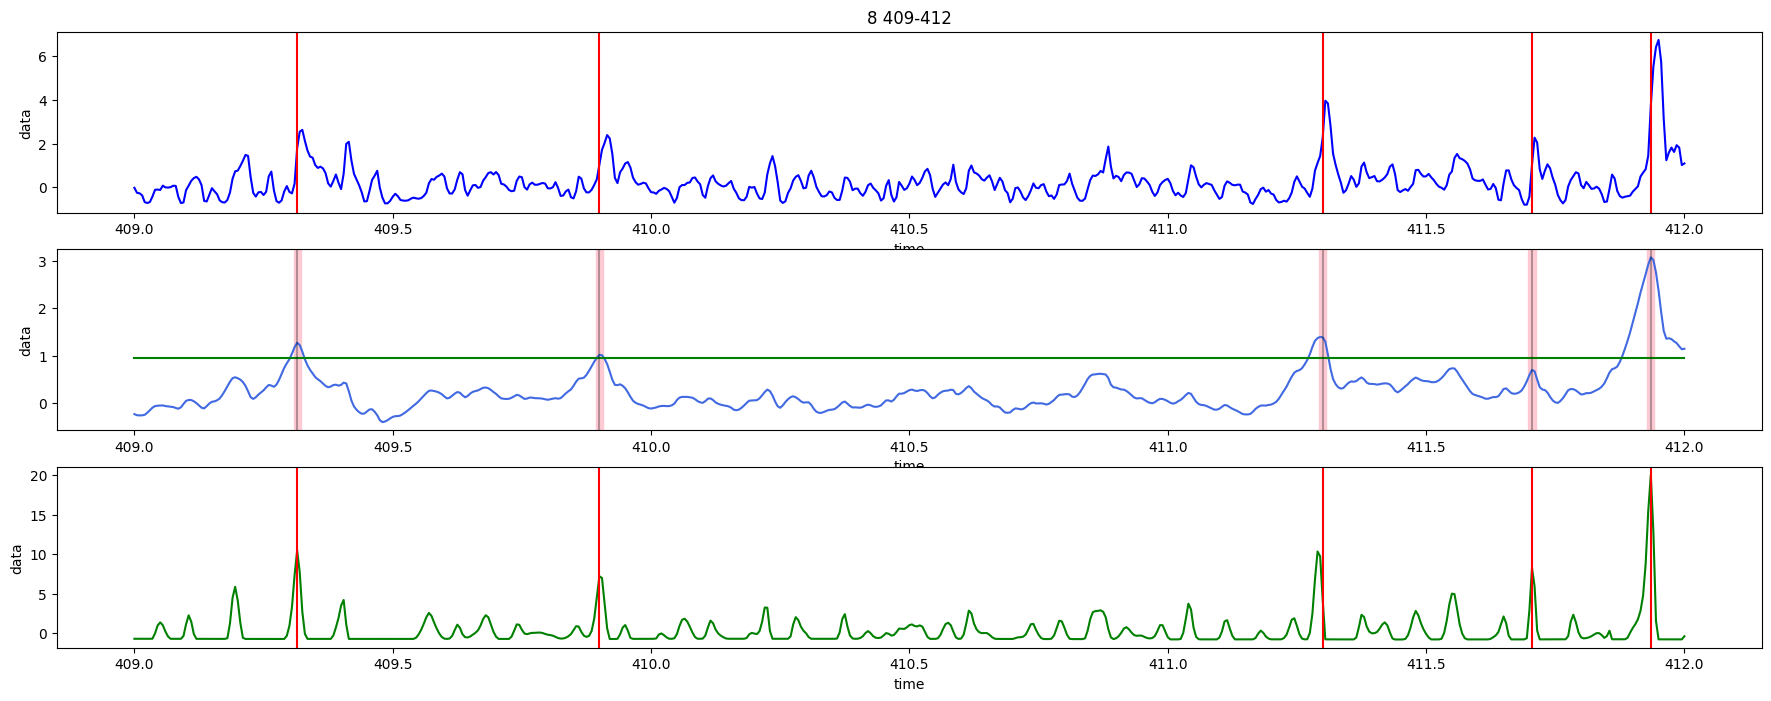

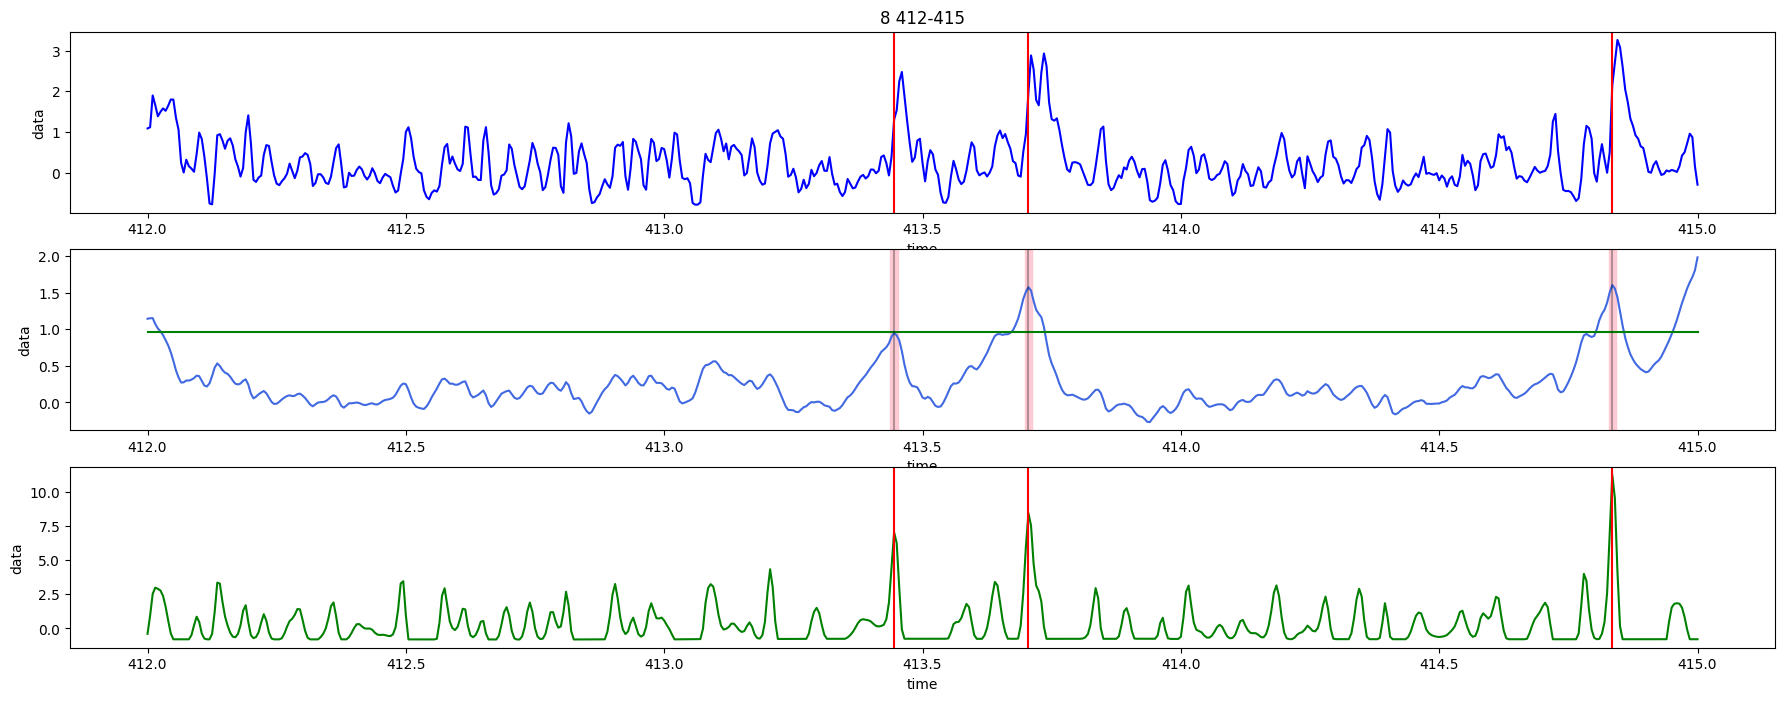

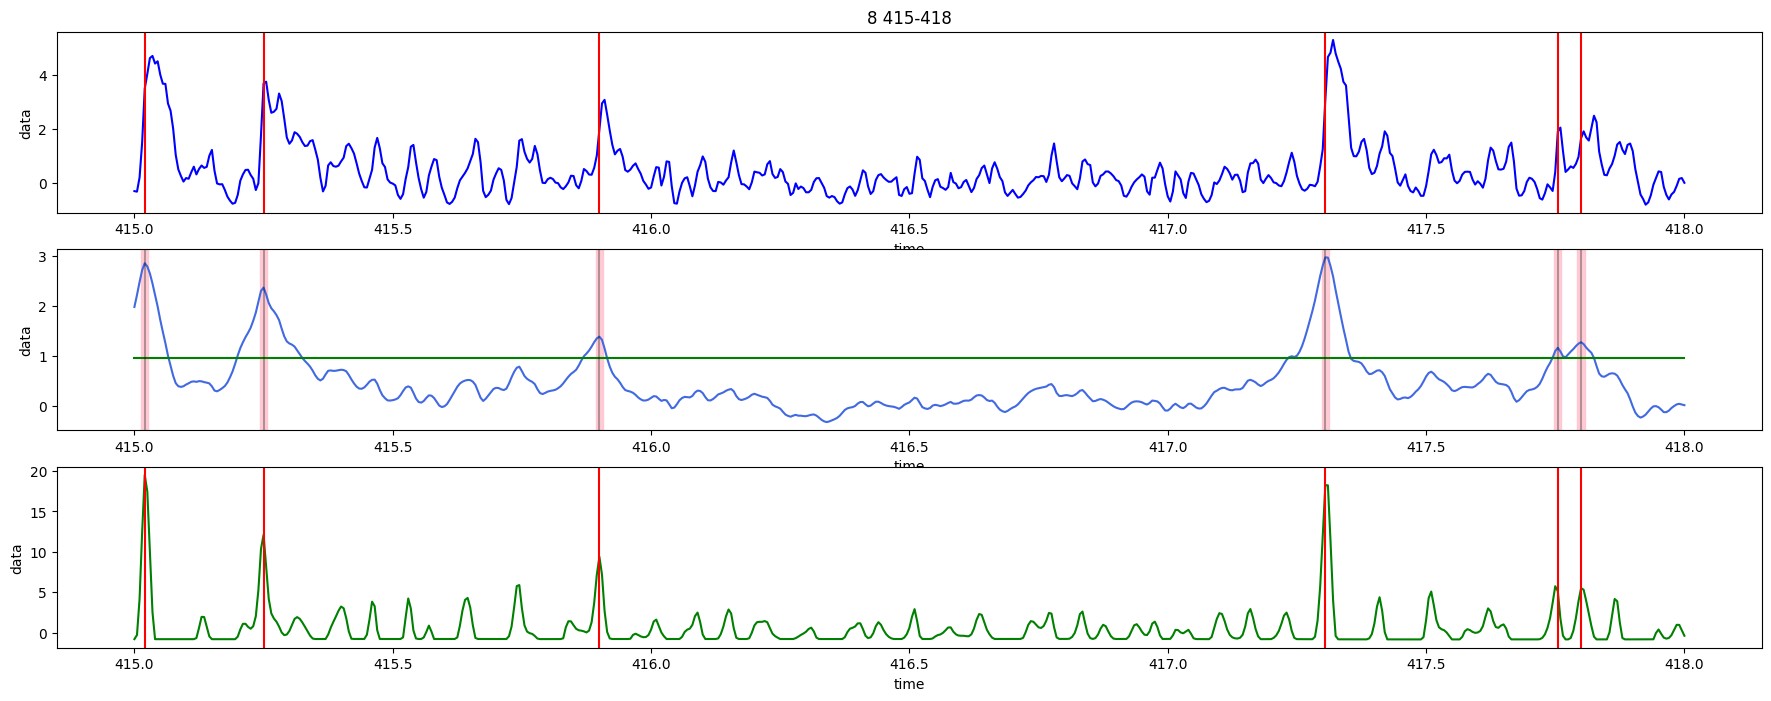

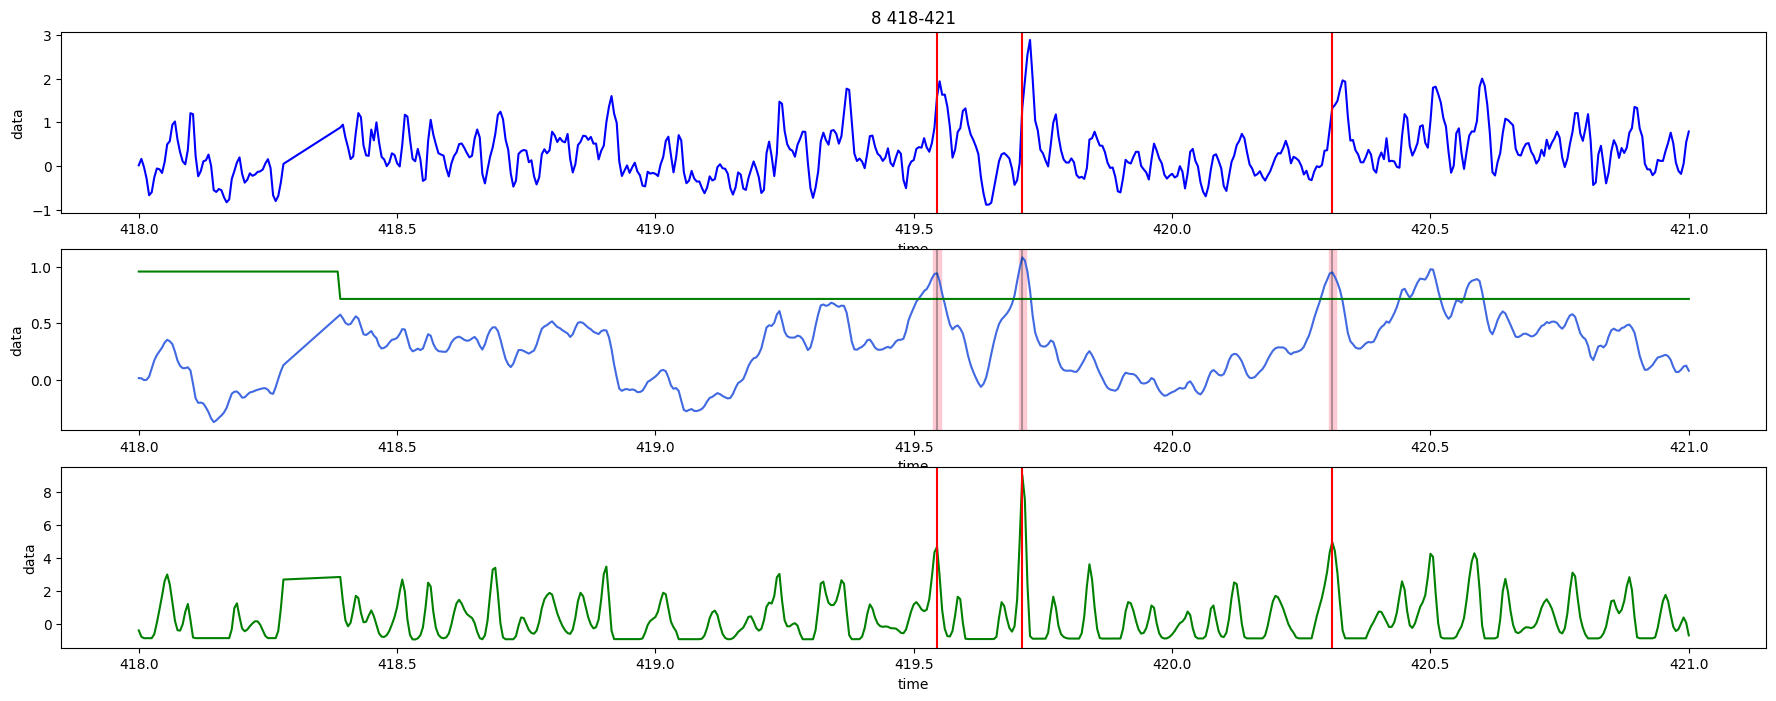

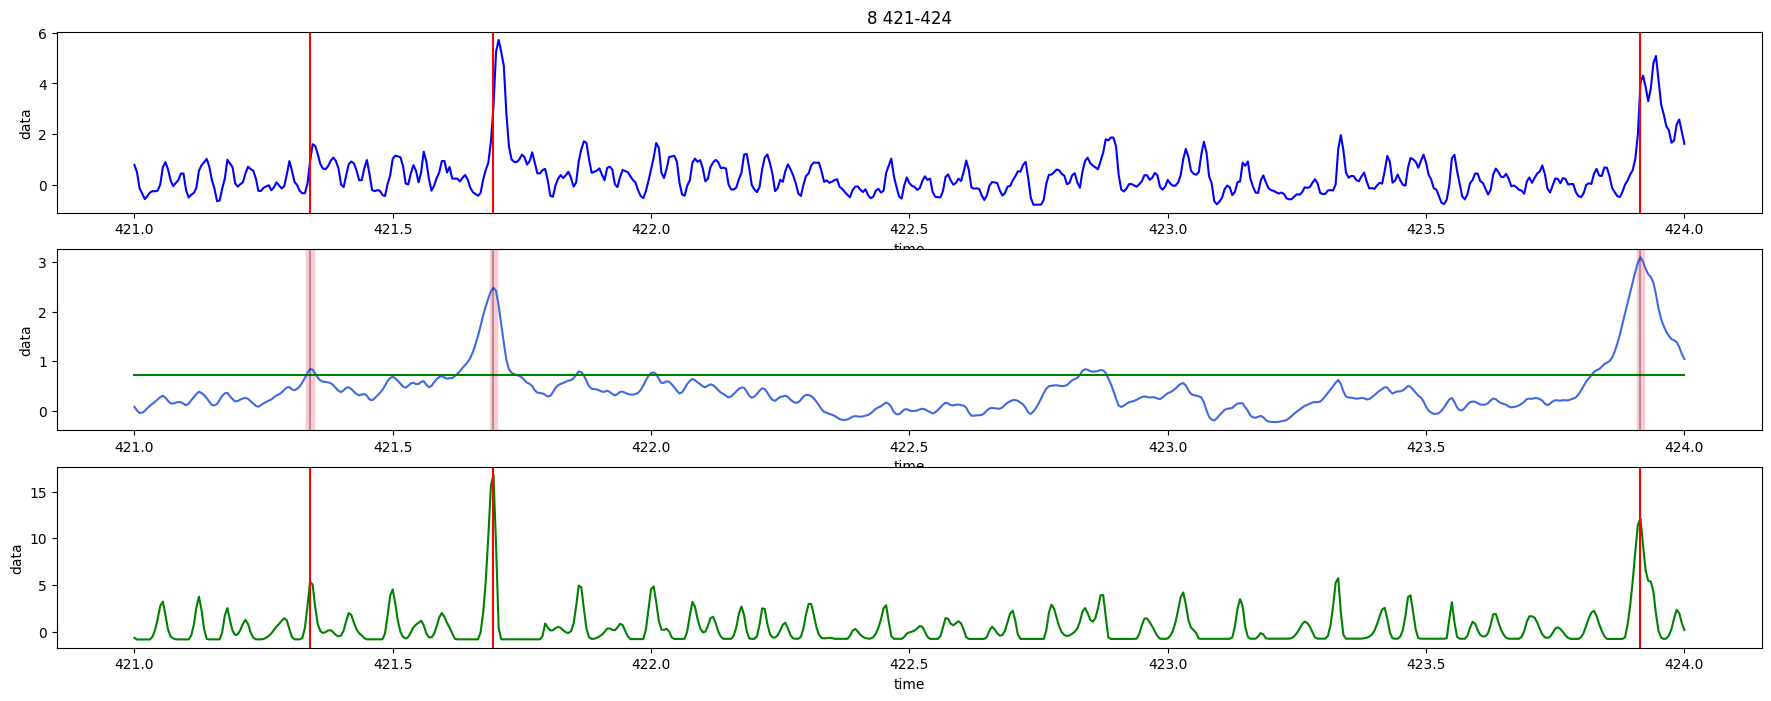

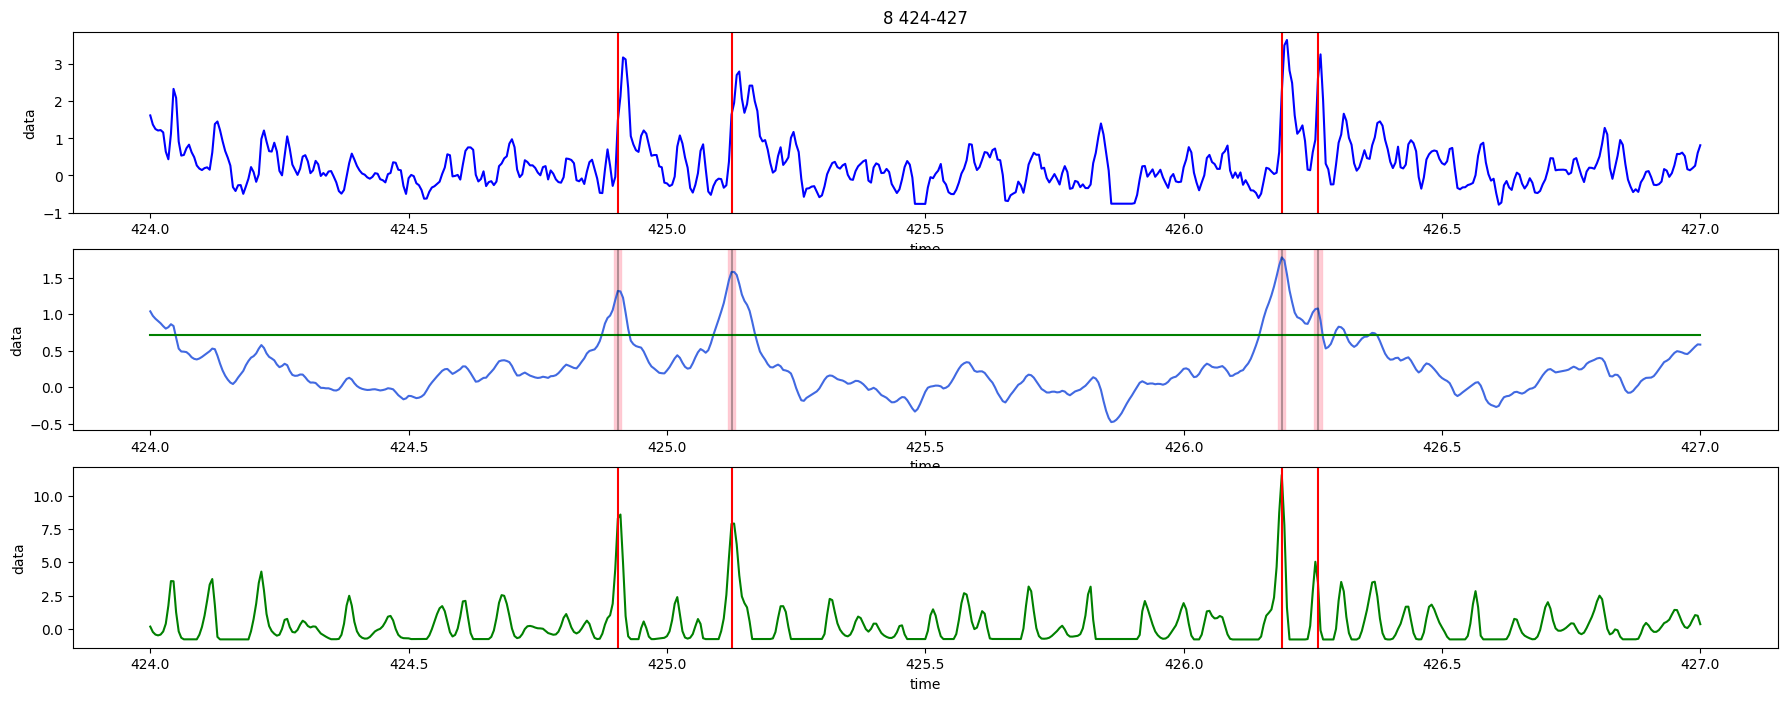

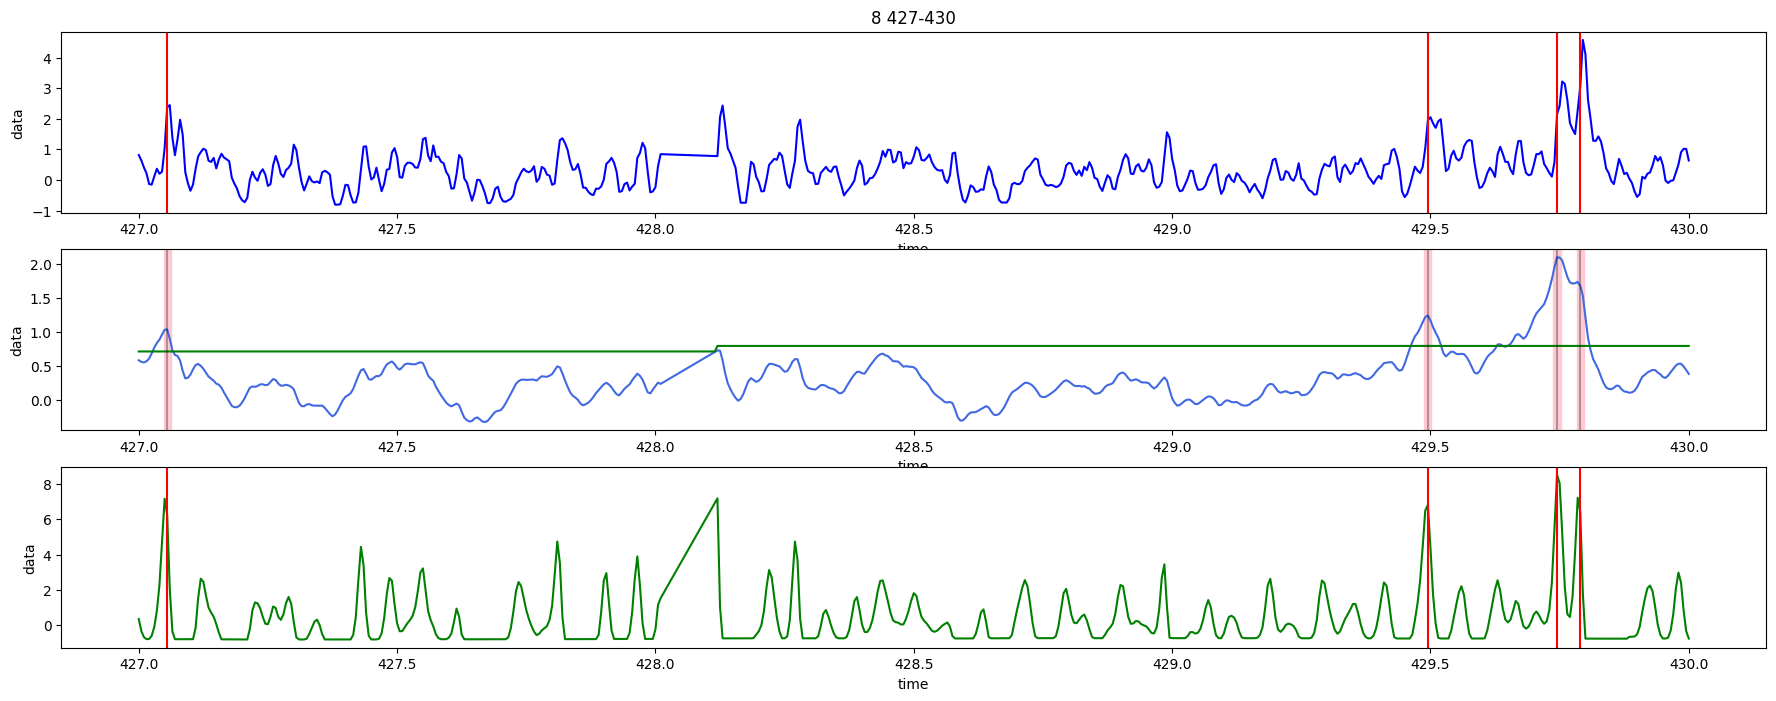

In [248]:
syn=8
for t1 in np.arange(400, 430, 3):
    t2 = t1 + 3
    s1evs = detres['events'].loc[detres['events'].synapse==syn]['t_sec'].values
    f, ax = plt.subplots(3, 1, figsize=(22, 8))
    sns.lineplot(data=nn.ss(2, syn).ts(t1, t2), ax=ax[0], x='time', y='data', color='blue')
    
    sns.lineplot(data=mf.ss(2, syn).ts(t1, t2), ax=ax[1], x='time', y='data', color='royalblue')
    sns.lineplot(data=mf.ss(2, syn).ts(t1, t2), ax=ax[1], x='time', y='nthresh', color='green')
    
    sns.lineplot(data=ev.ss(2, syn).ts(t1, t2), ax=ax[2], x='time', y='data', color='green')
    
    evs2p = s1evs[(s1evs>t1)&(s1evs<t2)]
    for evnt in evs2p:
        ax[0].axvline(evnt, color='red')
        ax[1].axvline(evnt, color='k', alpha=0.3)
        ax[2].axvline(evnt, color='red')
        ax[1].axvspan(evnt-0.007, evnt+0.007, color='pink', alpha=0.8)
    ax[0].set_title(f'{syn} {t1}-{t2}')
    plt.show()

In [186]:
g2_clean = g2.filter(pl.col("mfsnr")>0.8)
g2_clean = g2_clean.filter(pl.col("mfsnr").is_not_nan())

In [189]:
syn_group_1 = np.arange(0, 10)
syn_group_2 = np.arange(15, 45)

In [196]:
for i, sg in enumerate([syn_group_1, syn_group_2]):
    evdf = g2_clean.filter(pl.col("synapse").is_in(sg))
    ev_times = evdf['t_sec'].to_numpy()
    ev_sources = evdf['synapse'].to_numpy()
    ev_sources = ev_sources - ev_sources.min()
    ev_snr = evdf['mfsnr'].to_numpy()
    # normalize ev_snr to values between 0.5 and 1
    ev_alphas = 0.5 + (ev_snr - ev_snr.min()) / (ev_snr.max() - ev_snr.min()) * 0.5
    np.save(f'ev_times_{i}.npy', ev_times)
    np.save(f'ev_sources_{i}.npy', ev_sources)
    np.save(f'ev_alphas_{i}.npy', ev_alphas)

In [ ]:
ev1 = g2_clean.filter(pl.col('synapse').is_in(syn_group_1))
ev2 = g2_clean.filter(pl.col('synapse').is_in(syn_group_2))

In [ ]:
for src in np.arange(20):
    s1evs = detres['events'].loc[detres['events'].synapse==src]
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.histplot(s1evs['amp_peak'], bins='auto', ax=ax)
    ax.set_title(f'src {src}')
    plt.show()

In [ ]:
root = f'{DEFS.anmat_root}/event_labels'

In [50]:
detres['events'].groupby('synapse').count()

,start_idx,end_idx,peak_idx,t_sec,amp_peak,amp_sum,width_s,sigma,snr_peak,alpha
synapse,,,,,,,,,,
0,3169,3169,3169,3169,3169,3169,3169,3169,3169,3169
1,1088,1088,1088,1088,1088,1088,1088,1088,1088,1088
2,2072,2072,2072,2072,2072,2072,2072,2072,2072,2072
3,3578,3578,3578,3578,3578,3578,3578,3578,3578,3578
4,2328,2328,2328,2328,2328,2328,2328,2328,2328,2328
5,3668,3668,3668,3668,3668,3668,3668,3668,3668,3668
6,2532,2532,2532,2532,2532,2532,2532,2532,2532,2532
7,3024,3024,3024,3024,3024,3024,3024,3024,3024,3024
8,3165,3165,3165,3165,3165,3165,3165,3165,3165,3165


In [ ]:
dmd, source = 2, 0
s1 = ev.ss(dmd, source)
m1 = mf.ss(dmd, source)

<Axes: xlabel='time', ylabel='data'>

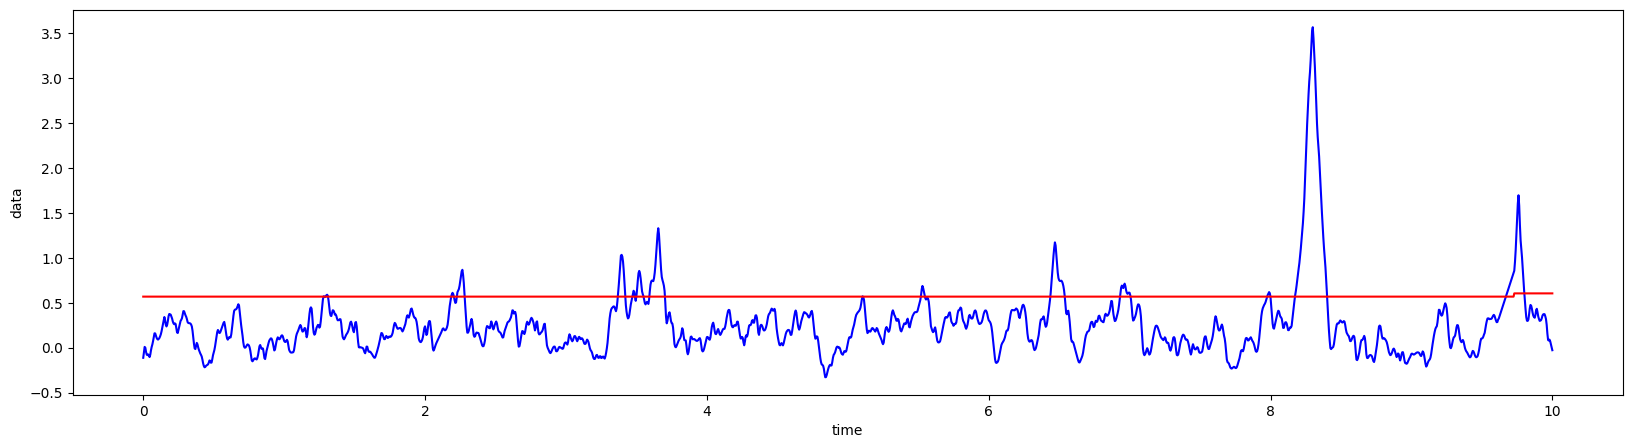

In [38]:
f, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(data=m1.ts(0, 10), ax=ax, x='time', y='data', color='blue')
sns.lineplot(data=m1.ts(0, 10), ax=ax, x='time', y='nthresh', color='red')

<Axes: xlabel='time', ylabel='data'>

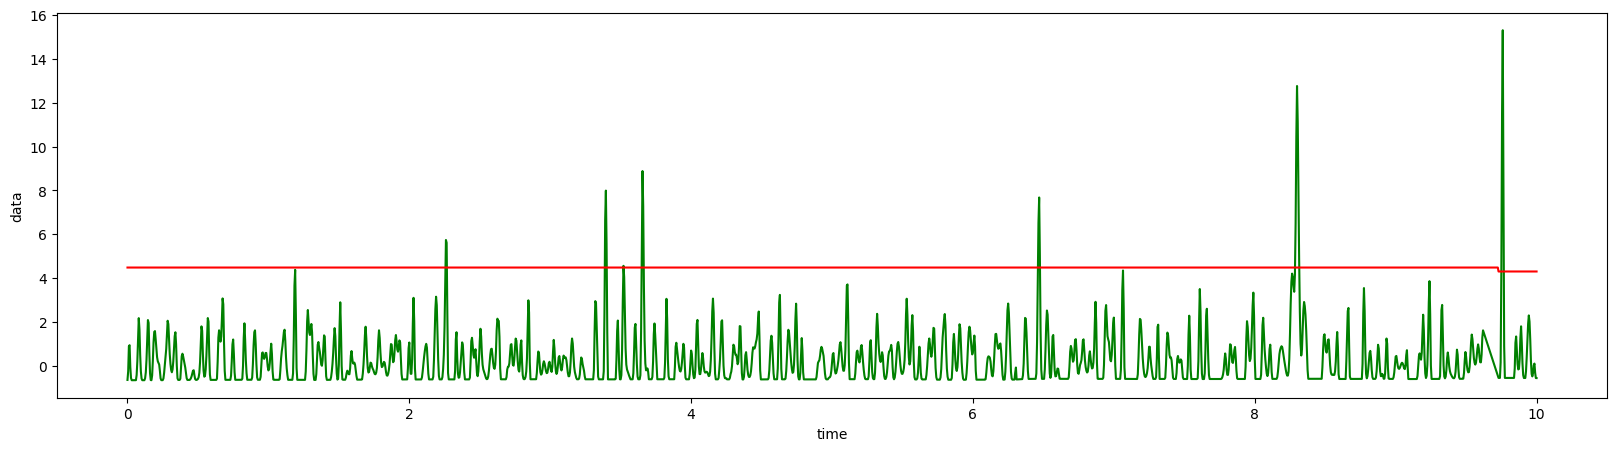

In [39]:
f, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(data=s1.ts(0, 10), ax=ax, x='time', y='data', color='green')
sns.lineplot(data=s1.ts(0, 10), ax=ax, x='time', y='nthresh', color='red')